In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#imports
import os
import glob
import random
from scipy.io import loadmat
import numpy as np
import cv2

import keras
from keras.layers import (Input,Activation, Conv2D, Dropout, Convolution2D,UpSampling2D)
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,Conv2DTranspose,
                  Add,MaxPooling2D,MaxPooling3D, Input, Concatenate,BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import mean_absolute_error
from keras.models import Sequential,load_model,Model
from keras.optimizers import Adam
import os, math
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf


Using TensorFlow backend.


In [3]:
#data paths

driveroot="/content/gdrive/My Drive"

rgbdir="/content/gdrive/My Drive/NTIRE2020_Clean"
hsdir="/content/gdrive/My Drive/NTIRE2020"

hpath=hsdir+'/ARAD_HS_*.mat'
rpath_clean=rgbdir+'/ARAD_HS_*_clean.png'
# print(rgbdir,hsdir,hpath,rpath_clean)

num_samples=230#number of files to load

hlist=glob.glob(hpath)[0:num_samples]
rgblist=glob.glob(rpath_clean)[0:num_samples]
print("number of hyperspectral imgs:",len(hlist))
print("number of rgb images:",len(rgblist))

number of hyperspectral imgs: 230
number of rgb images: 230


In [11]:
#validation sets
Y_val=np.load(driveroot+"/Colab Notebooks/RGB2Hyperspectral group 45 cnn/ntire2020_hs_validationset_10.npy")
X_val=np.load(driveroot+"/Colab Notebooks/RGB2Hyperspectral group 45 cnn/ntire2020_rgbclean_validationset_10.npy")
print("Validation set:",hs_val.shape, rgbclean_val.shape)

Validation set: (10, 482, 512, 31) (10, 482, 512, 3)


In [0]:
#model params
epochs=5
batch_size=8
lr=0.0001

initial_epoch=0

model_save_dir="/content/gdrive/My Drive/Colab Notebooks/RGB2Hyperspectral group 45 cnn/models"
model_name="cnn_init_5n"
version=2

In [6]:
def load_batch_hyper(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        x=loadmat(filelist[i])
        matimg=x['cube']
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData

y=load_batch_hyper(hlist[5:10])
y.shape

(5, 482, 512, 31)

In [7]:
def load_batch_rgb(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        matimg = cv2.imread(filelist[i])
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData
x=load_batch_rgb(rgblist[5:10])
x.shape

(5, 482, 512, 3)

In [0]:
def imageLoader(files_x,files_y, batch_size):
    L = len(files_x)
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = load_batch_rgb(files_x[batch_start:limit])
            Y = load_batch_hyper(files_y[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [0]:
# from sklearn.model_selection import train_test_split
# X_data,Y_data=rgb_numpyData,final_numpyData
# X_train,  X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2)		

# print("Training data and Ground truth shape.................",X_train.shape,Y_train.shape)
# print('Validation Split Completed...........................', X_val.shape, Y_val.shape)

Training data and Ground truth shape................. (40, 482, 512, 3) (40, 482, 512, 31)
Validation Split Completed........................... (10, 482, 512, 3) (10, 482, 512, 31)


In [0]:
class model_rgb2hs():

    def __init__(self, image_size):
        self.image_size = image_size

    def Cnn(self):
        inp = Input((None, None,3))
        C1 = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(inp)
        C2 = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(C1) 
        C3 = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(C2) 
        C4 = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(C3)
        Cout = Conv2D(31, kernel_size=(3,3), padding='same', activation='relu')(C4)
        model = Model(inp, Cout)
        return model


In [0]:
m=model_rgb2hs(246784)
model=m.Cnn()

In [12]:
model.compile(loss='mean_absolute_error', optimizer=Adam(lr=lr), metrics=['mae','mse'])
checkpoint = keras.callbacks.ModelCheckpoint(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_{epoch:02d}-{loss:.4f}.h5',monitor='loss',verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=50)
csv_logger = keras.callbacks.CSVLogger(model_save_dir + "/tr_-v"+str(version)+".csv", separator=',', append=True)

history=model.fit_generator(imageLoader(rgblist,hlist,batch_size), validation_data=(X_val, Y_val), steps_per_epoch=math.ceil(num_samples/batch_size), epochs=epochs,verbose=1,callbacks=[checkpoint, csv_logger], shuffle=True)
# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, initial_epoch=initial_epoch,
 					# validation_split=0.2,callbacks=[checkpoint, csv_logger], shuffle=False)
# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, 
                            # validation_data=(X_val, Y_val), shuffle=True)

Epoch 1/5
29/29 [==============================] - 486s 17s/step - loss: 0.2809 - mae: 0.2827 - mse: 0.7362 - val_loss: 0.2174 - val_mae: 0.2174 - val_mse: 0.0845
Epoch 2/5
29/29 [==============================] - 403s 14s/step - loss: 0.1318 - mae: 0.1324 - mse: 0.0441 - val_loss: 0.2064 - val_mae: 0.2064 - val_mse: 0.0769
Epoch 3/5
29/29 [==============================] - 426s 15s/step - loss: 0.1237 - mae: 0.1242 - mse: 0.0399 - val_loss: 0.1959 - val_mae: 0.1959 - val_mse: 0.0718
Epoch 4/5
29/29 [==============================] - 397s 14s/step - loss: 0.1175 - mae: 0.1180 - mse: 0.0370 - val_loss: 0.1851 - val_mae: 0.1851 - val_mse: 0.0660
Epoch 5/5
29/29 [==============================] - 402s 14s/step - loss: 0.1118 - mae: 0.1123 - mse: 0.0344 - val_loss: 0.1780 - val_mae: 0.1780 - val_mse: 0.0637


In [13]:
history.history

{'loss': [0.2826613801329032,
  0.13239820891100426,
  0.12420819447092388,
  0.1179943288150041,
  0.11229877808819647],
 'mae': [0.28266135, 0.13239822, 0.12420819, 0.117994316, 0.11229879],
 'mse': [0.73624593, 0.04412967, 0.039873853, 0.036962412, 0.034357682],
 'val_loss': [0.21740611493587494,
  0.2064223498106003,
  0.19592911005020142,
  0.18507975339889526,
  0.1780151307582855],
 'val_mae': [0.21740610897541046,
  0.2064223438501358,
  0.19592911005020142,
  0.18507975339889526,
  0.17801514267921448],
 'val_mse': [0.08448464423418045,
  0.07690976560115814,
  0.07180652022361755,
  0.06598059087991714,
  0.06371141225099564]}

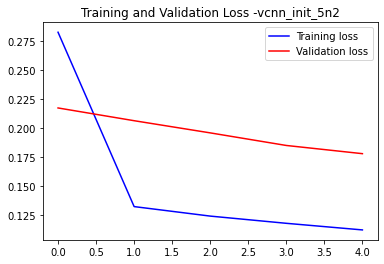

In [14]:
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss -v'+str(model_name)+str(version))
plt.legend()
plt.savefig(os.path.join(model_save_dir, str(model_name)+'_train_loss_'+str(version)+'_'+str(epochs)+'.png')) 
# plt.show()

In [15]:
model_json = model.to_json()
with open(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.json', "w+") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5')
print("Saved model to disk")

Saved model to disk


In [16]:
sample_x,sample_y=X_val[0],Y_val[0]
y_pred=model.predict(np.expand_dims(sample_x,axis=0))
y_pred.shape

(1, 482, 512, 31)

In [17]:
sample_y.shape

(482, 512, 31)

In [18]:
rmaee=abs(sample_y-y_pred[0])/sample_y
rmaee.shape

(482, 512, 31)

In [21]:
rmaee

array([[[1.00000000e+00, 1.63681123e-01, 1.00000000e+00, ...,
         1.00000000e+00, 2.28294991e+00, 1.00000000e+00],
        [1.00000000e+00, 2.02863408e-02, 1.00000000e+00, ...,
         1.00000000e+00, 1.22347522e+00, 1.00000000e+00],
        [1.00000000e+00, 1.12232367e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        ...,
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.18958187e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         5.85133438e+00, 1.21130083e-01, 1.00000000e+00]],

       [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 6.41357189e+00, 1.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.27770868e+00, 

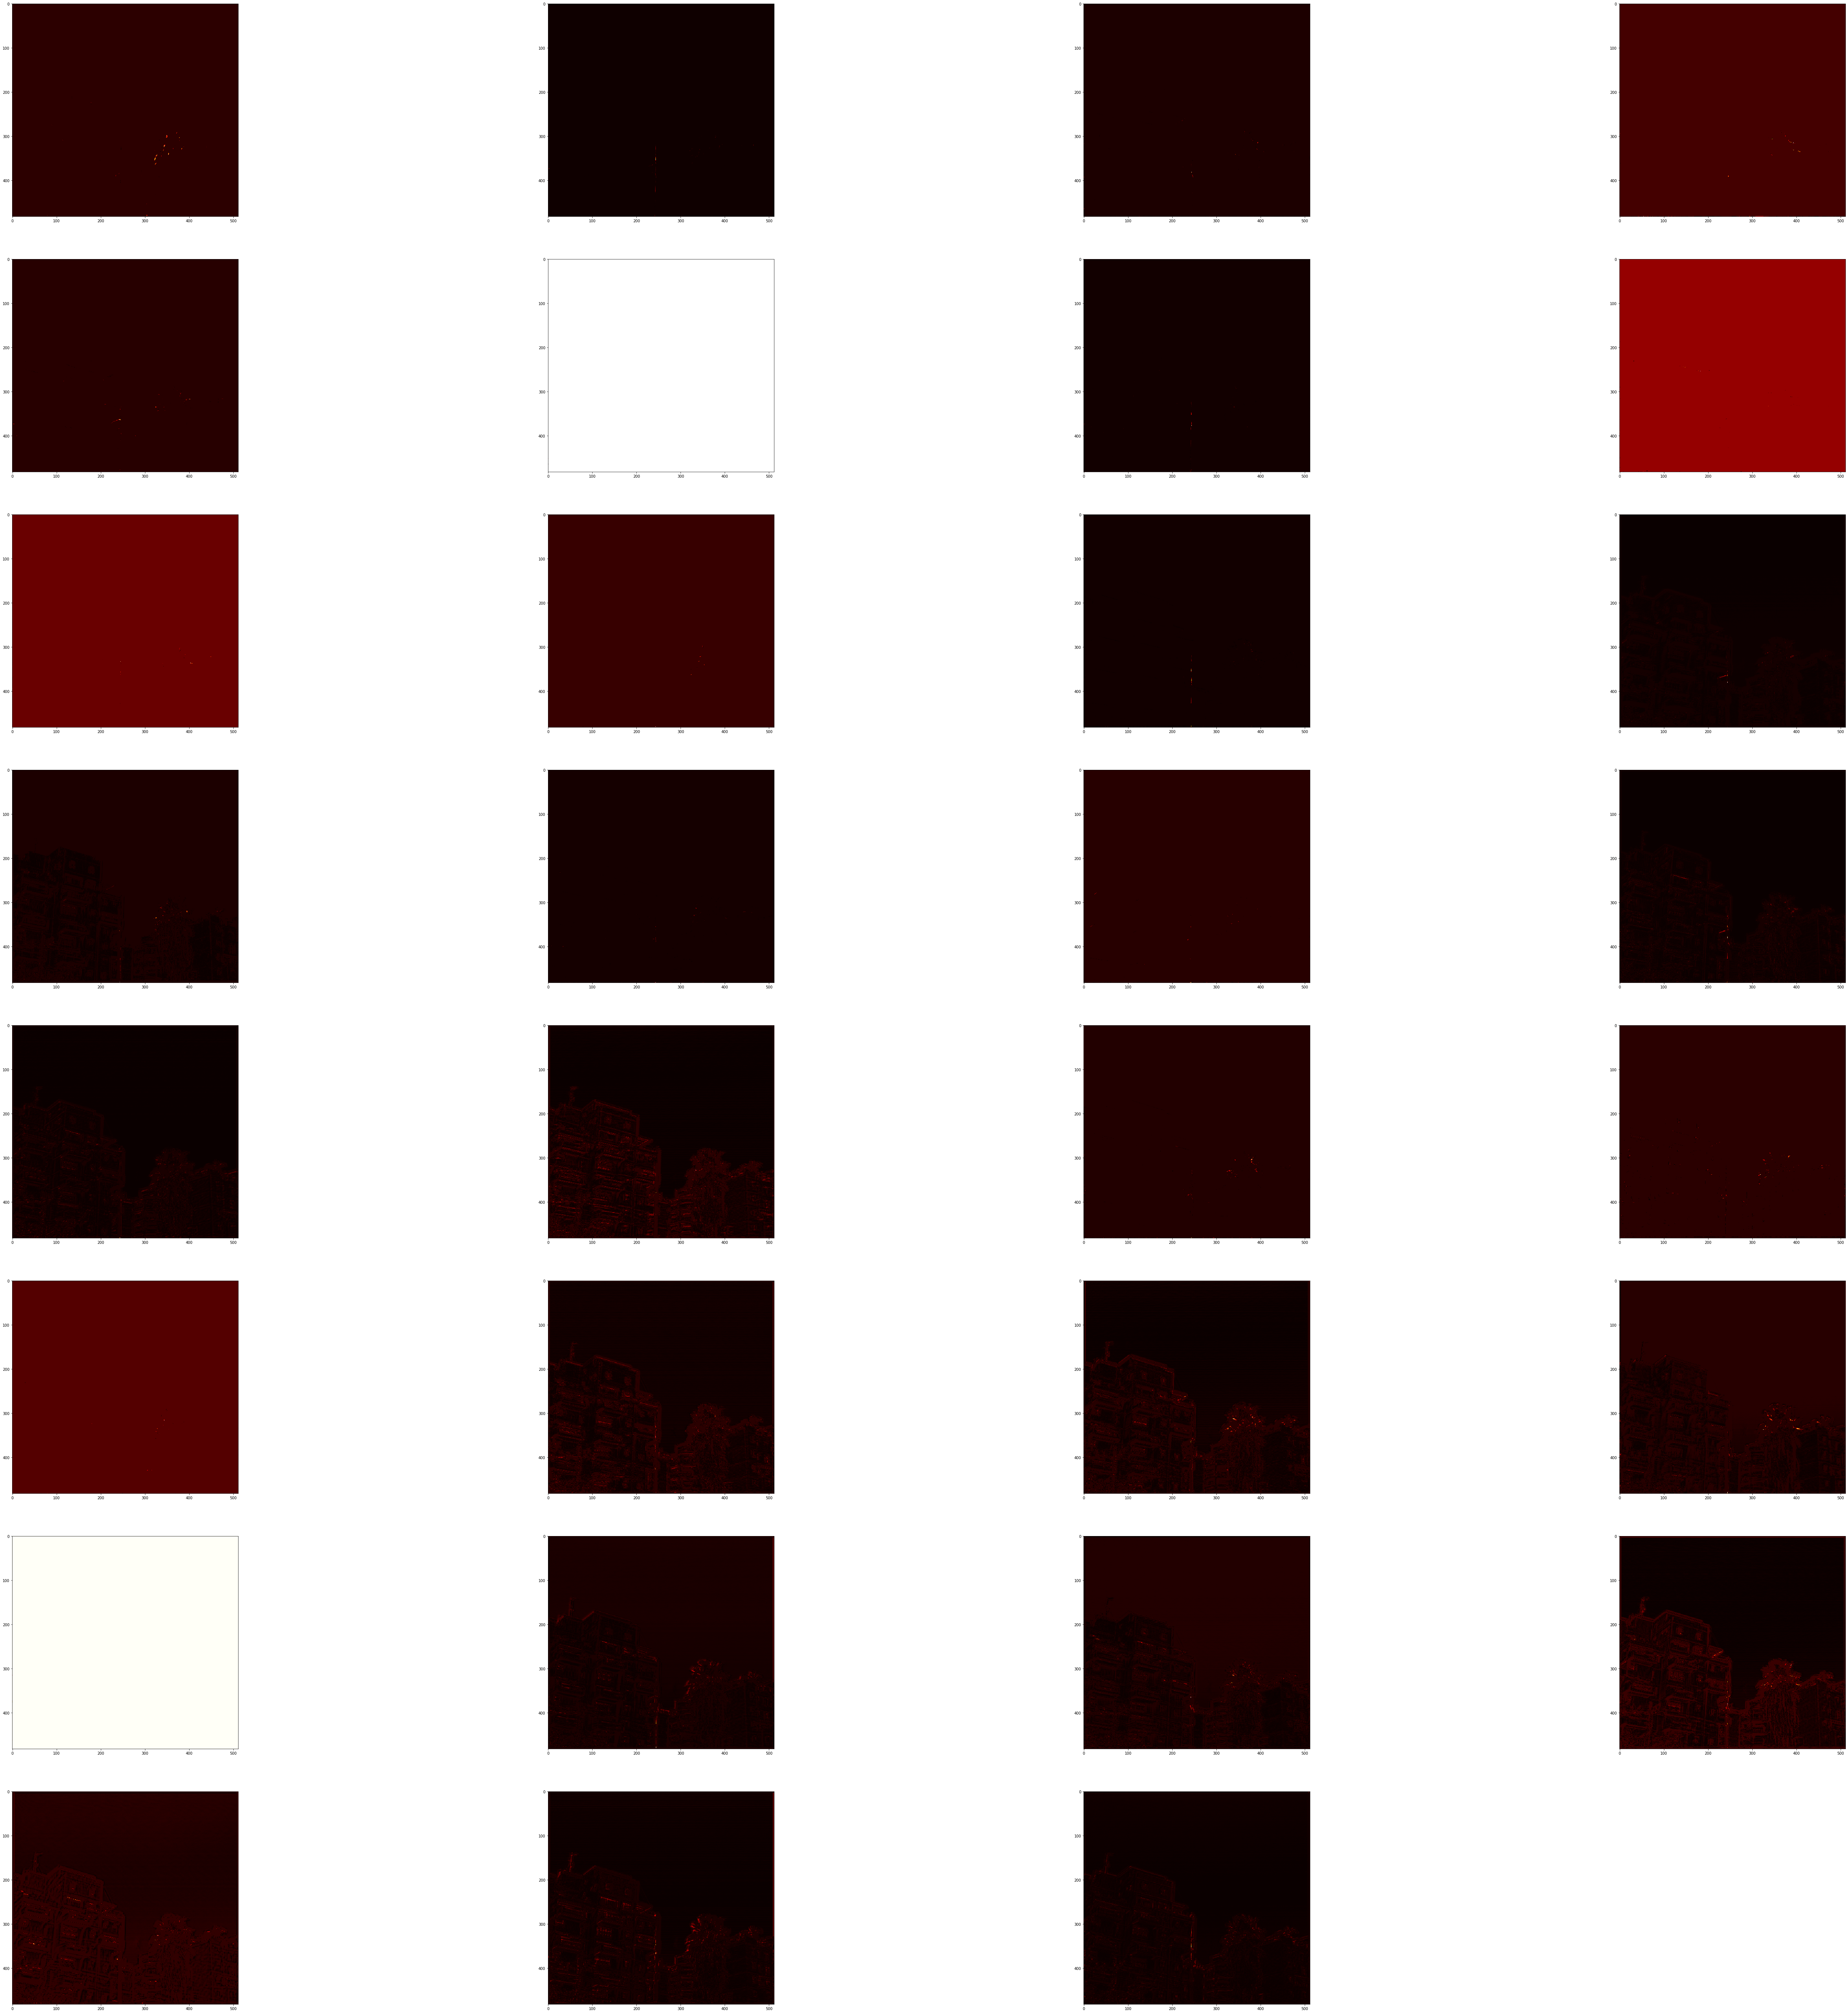

In [32]:
f=plt.figure(figsize=(100, 100))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(rmaee[:,:,i],cmap=plt.get_cmap('hot'), interpolation='nearest')
# plt.show()

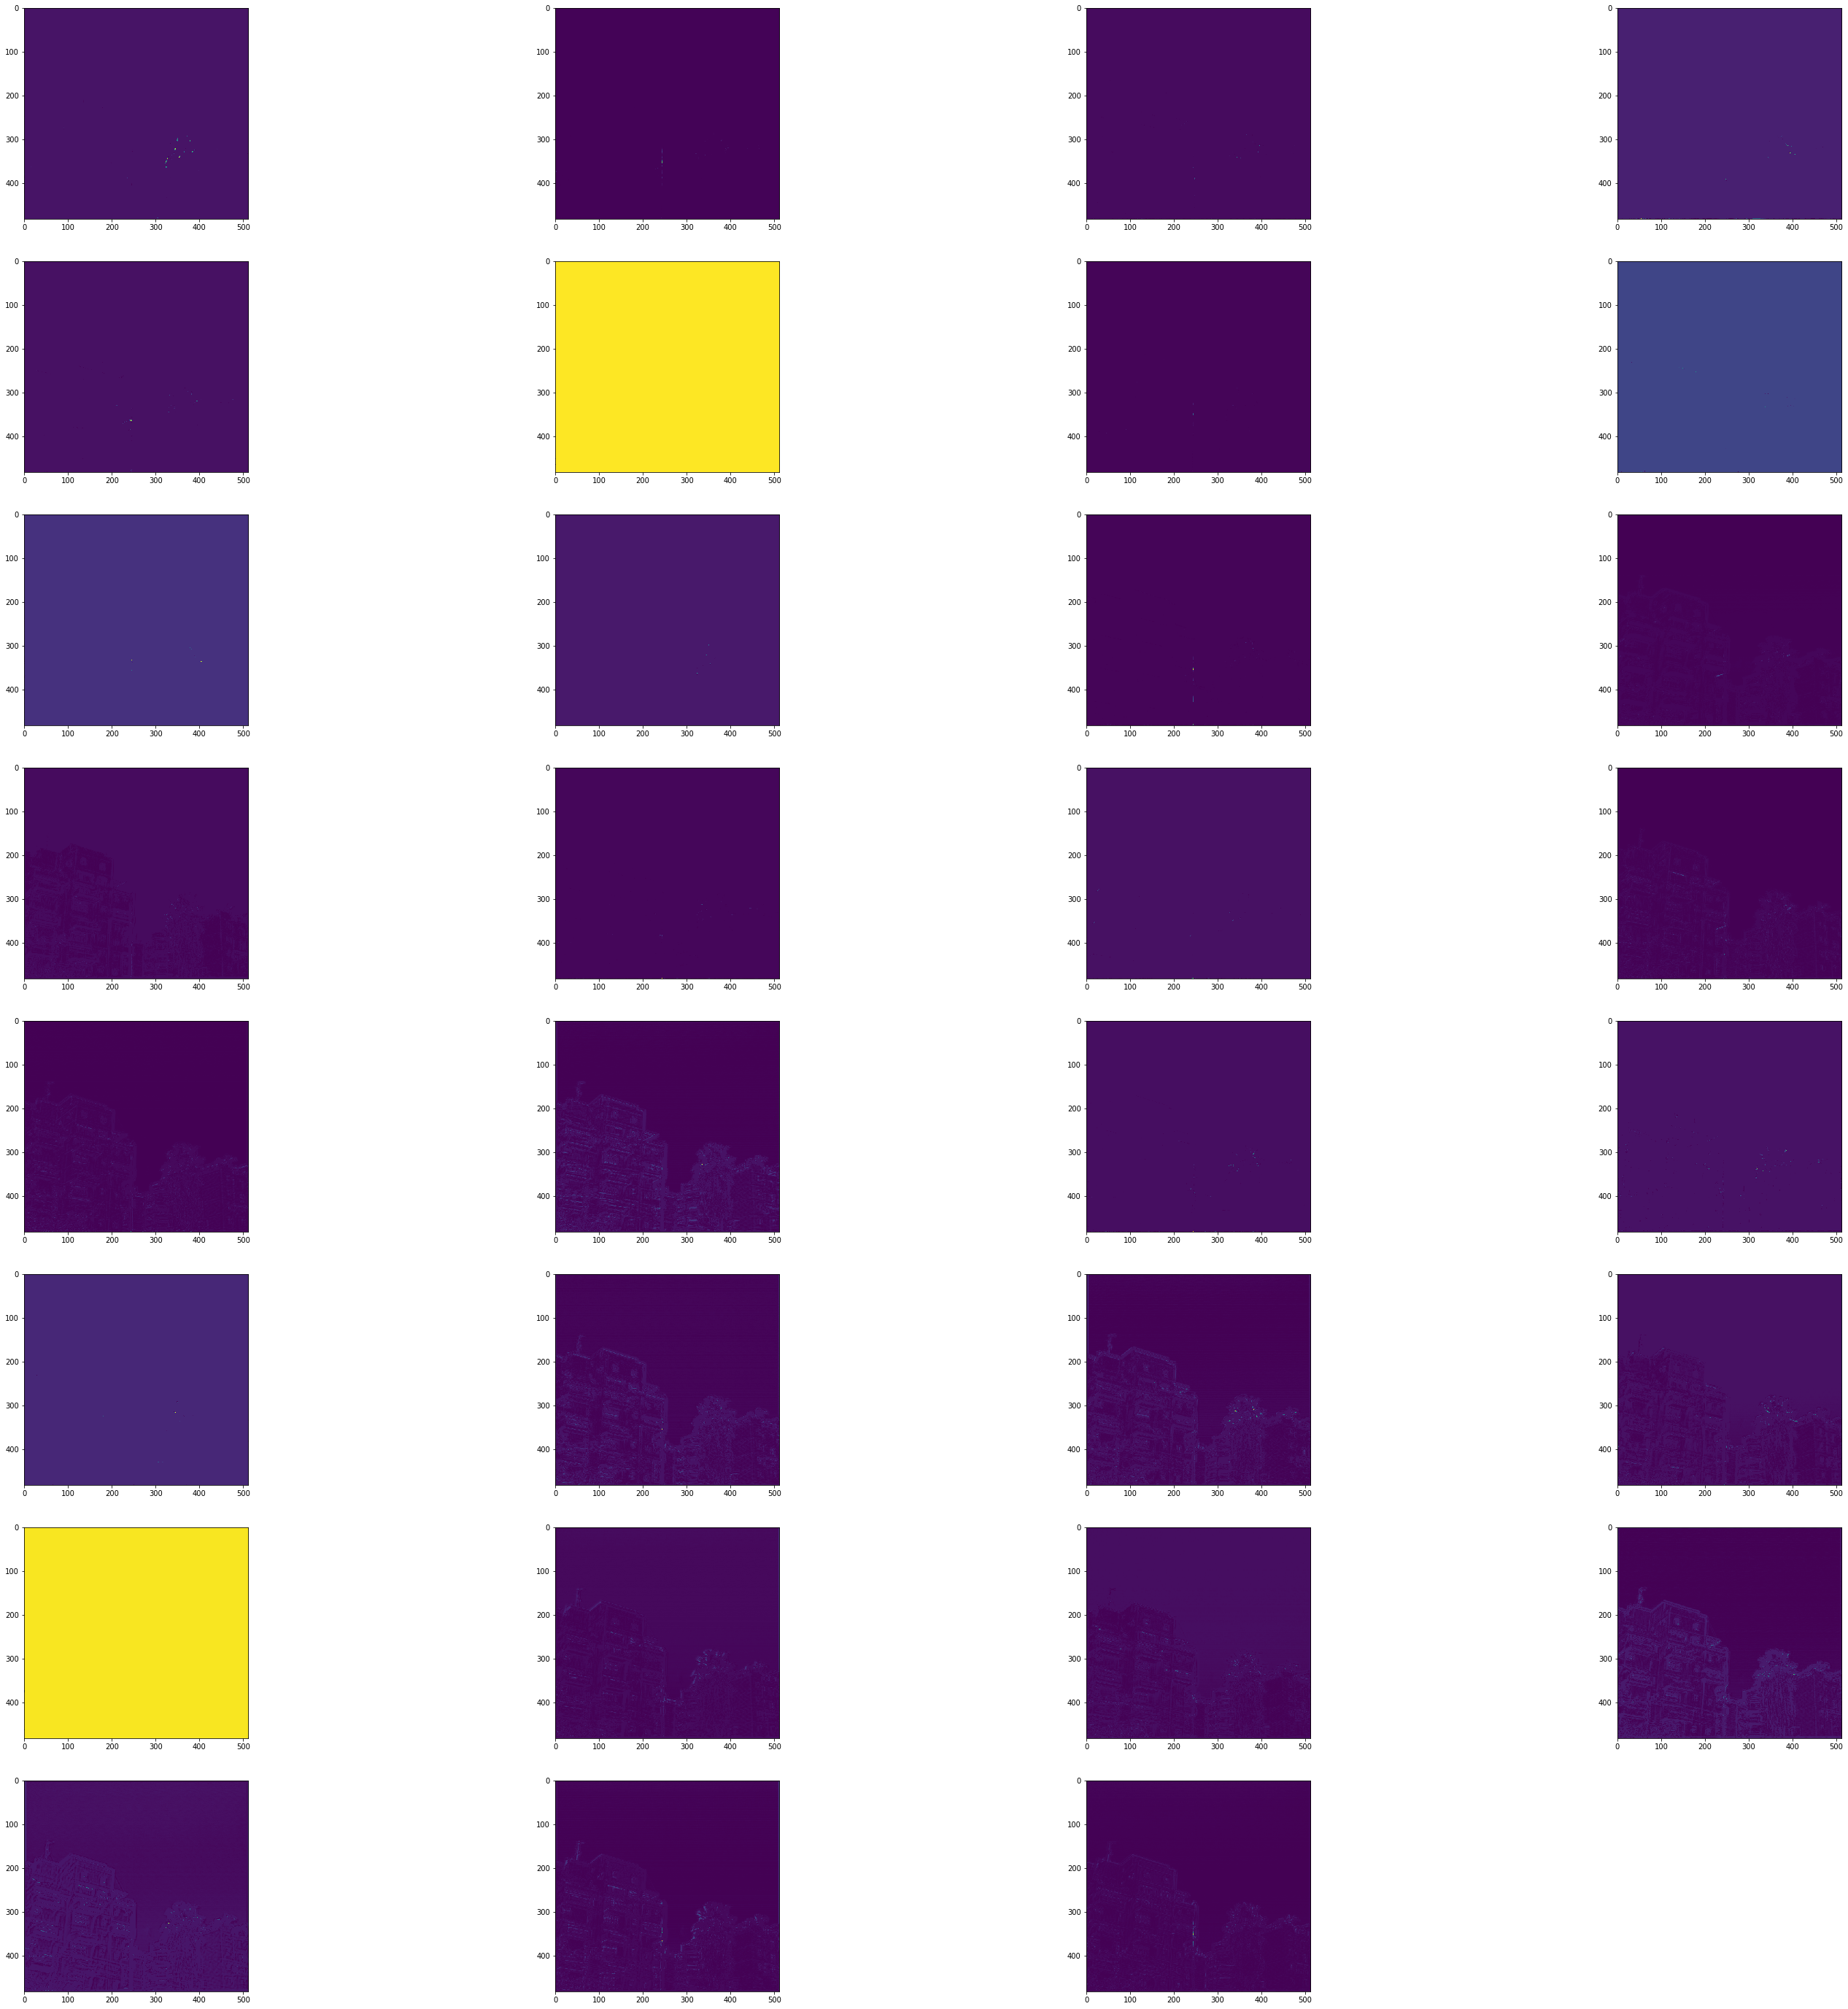

In [34]:
g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(rmaee[:,:,i],cmap='viridis', interpolation='nearest')

In [0]:
np.save(model_save_dir+"/abs_errs.npy", rmaee)

In [0]:
plt.imsave(model_save_dir+'/test.png', rmaee[0])